# 5: NPV Score Simulation

### Import relevant packages 

In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### NPV Buy and NPV Rent

In [ ]:
def annuitaet_zahlung(kreditsumme: float, zins: float, tilgung: float) -> float:

    if kreditsumme <= 0:
        return 0.0
    if zins < 0 or tilgung < 0:
        raise ValueError("Zins und Tilgung müssen > 0 sein")

    return kreditsumme * (zins + tilgung)

def npv_kaufen(kaufpreis_pro_m2: float, zins: float, erwartete_rendite: float, tilgung: float, betrachtungszeitraum: int = 10, 
               wohnflaeche_m2: float = 80.0, eigenkapitalquote: float = 0.20, kaufnebenkosten_quote: float = 0.10, 
               verkaufskosten_quote: float = 0.05, instandhaltung_quote: float = 0.01, preissteigerung_immobilie: float = 0.02,
               steuersatz_veraeusserungsgewinn: float = 0.25) -> float:
    
    H = int(betrachtungszeitraum)
    if H <= 0:
        return np.nan

    # Initialwerte
    kaufpreis = float(kaufpreis_pro_m2) * float(wohnflaeche_m2)
    kaufnebenkosten = kaufpreis * kaufnebenkosten_quote
    anschaffungskosten = kaufpreis + kaufnebenkosten
    eigenkapital = eigenkapitalquote * anschaffungskosten
    darlehen = anschaffungskosten - eigenkapital
    annuitaet = annuitaet_zahlung(darlehen, zins, tilgung)
    restschuld = darlehen

    # CF Betrachtung    
    cashflows = np.zeros(H + 1)
    # CF0
    cashflows[0] = -eigenkapital
    # CF1 bis CFH+1
    for t in range(1, H + 1):
        immowert_t = kaufpreis * (1.0 + preissteigerung_immobilie) ** t
        zinsen_t = restschuld * zins
        tilgung_t = max(0.0, annuitaet - zinsen_t)
        tilgung_t = min(tilgung_t, restschuld)
        restschuld = max(0.0, restschuld - tilgung_t)
        instandhaltung_t = instandhaltung_quote * immowert_t
        cashflows[t] = -(zinsen_t + tilgung_t) - instandhaltung_t

    # CFH: CF bei Verkauf
    immowert_H = kaufpreis * (1.0 + preissteigerung_immobilie) ** H
    verkaufserloes_netto = immowert_H * (1.0 - verkaufskosten_quote)
    veraeusserungsgewinn = verkaufserloes_netto - anschaffungskosten

    steuer = 0.0
    if H < 10:
        steuer = max(0.0, veraeusserungsgewinn) * steuersatz_veraeusserungsgewinn

    cashflows[H] += (verkaufserloes_netto - steuer - restschuld)

    # Discounting Cash Flows
    diskontfaktoren = np.array([(1.0 + erwartete_rendite) ** t for t in range(H + 1)])
    kapitalwert = float(np.sum(cashflows / diskontfaktoren))
    return kapitalwert

def npv_mieten_und_investieren(mietpreis_pro_m2: float, rendite_invest: float, erwartete_rendite: float, betrachtungszeitraum: int = 10, 
                               wohnflaeche_m2: float = 80.0, mietsteigerung: float = 0.02, 
                               # Buy Parameter: 
                               kaufpreis_pro_m2: float = 0.0, zins: float = 0.0, tilgung: float = 0.0, eigenkapitalquote: float = 0.20, 
                               kaufnebenkosten_quote: float = 0.10, instandhaltung_quote: float = 0.01, 
                               preissteigerung_immobilie: float = 0.02,
                               # Steuer (Endbesteuerung auf Gewinn)
                               kapitalertragssteuer_satz: float = 0.26375,) -> float:
    
    H = int(betrachtungszeitraum)
    if H <= 0:
        return np.nan

    # Budget = Annuität + Instandhaltungskosten 
    kaufpreis = float(kaufpreis_pro_m2) * float(wohnflaeche_m2)
    kaufnebenkosten = kaufpreis * kaufnebenkosten_quote
    anschaffungskosten = kaufpreis + kaufnebenkosten
    eigenkapital = eigenkapitalquote * anschaffungskosten
    darlehen = anschaffungskosten - eigenkapital
    annuitaet = annuitaet_zahlung(darlehen, zins, tilgung)

    # Initialmiete
    jahresmiete_0 = float(mietpreis_pro_m2) * float(wohnflaeche_m2) * 12.0

    # Initial-Investieren 
    vermoegen = float(eigenkapital)
    eingezahltes_geld = float(eigenkapital) # Summe der Einzahlungen ins Depot 

    # CF Betrachtung
    cashflows = np.zeros(H + 1, dtype=float)
    # CF0
    cashflows[0] = -float(eigenkapital)
    # CF1 bis CFH+1
    for t in range(1, H + 1):
        # budget_t = Annuität + Instandhaltungskosten
        immowert_t = kaufpreis * (1.0 + preissteigerung_immobilie) ** t
        instandhaltung_t = instandhaltung_quote * immowert_t
        budget_t = annuitaet + instandhaltung_t
        # Mietkosten + (Differenz) Investieren
        miete_t = jahresmiete_0 * (1.0 + mietsteigerung) ** (t - 1)
        sparen_t = budget_t - miete_t
        # Portfolioentwicklung
        vermoegen = vermoegen * (1.0 + rendite_invest) + sparen_t
        if sparen_t > 0:
            eingezahltes_geld += sparen_t

        # Budget als negativen Cashoutflow
        cashflows[t] = -budget_t

    # CFH: CF bei Verkauf
    gewinn = max(0.0, vermoegen - eingezahltes_geld)
    steuer = gewinn * float(kapitalertragssteuer_satz)
    vermoegen_netto = vermoegen - steuer

    cashflows[H] += vermoegen_netto
    # Discounting Cash Flows 
    diskontfaktoren = np.array([(1.0 + float(erwartete_rendite)) ** t for t in range(H + 1)], dtype=float)
    kapitalwert = float(np.sum(cashflows / diskontfaktoren))
    return kapitalwert

def npv_delta(kaufpreis_pro_m2: float, mietpreis_pro_m2: float, zins: float, tilgung: float, diskontsatz: float, rendite_invest: float,
    betrachtungszeitraum: int = 10, wohnflaeche_m2: float = 58.0, mietsteigerung: float = 0.02, kaufnebenkosten_quote: float = 0.10,
    eigenkapitalquote: float = 0.14, preissteigerung_immobilie: float = 0.03, instandhaltung_quote: float = 0.005,
    verkaufskosten_quote: float = 0.00, steuersatz_veraeusserungsgewinn: float = 0.25,) -> float:
   
    npv_buy = npv_kaufen(kaufpreis_pro_m2=kaufpreis_pro_m2, zins=zins, tilgung=tilgung, erwartete_rendite=diskontsatz, 
                         betrachtungszeitraum=betrachtungszeitraum, wohnflaeche_m2=wohnflaeche_m2, 
                         kaufnebenkosten_quote=kaufnebenkosten_quote, eigenkapitalquote=eigenkapitalquote,
                         preissteigerung_immobilie=preissteigerung_immobilie, instandhaltung_quote=instandhaltung_quote, 
                         verkaufskosten_quote=verkaufskosten_quote, steuersatz_veraeusserungsgewinn=steuersatz_veraeusserungsgewinn,)

    npv_rent_inv = npv_mieten_und_investieren(mietpreis_pro_m2=mietpreis_pro_m2, rendite_invest=rendite_invest, 
                                              erwartete_rendite=diskontsatz, betrachtungszeitraum=betrachtungszeitraum, 
                                              wohnflaeche_m2=wohnflaeche_m2, mietsteigerung=mietsteigerung, 
                                              kaufpreis_pro_m2=kaufpreis_pro_m2, zins=zins, tilgung=tilgung, 
                                              eigenkapitalquote=eigenkapitalquote, kaufnebenkosten_quote=kaufnebenkosten_quote, 
                                              instandhaltung_quote=instandhaltung_quote, 
                                              preissteigerung_immobilie=preissteigerung_immobilie,)

    npv_delta = npv_buy - npv_rent_inv
    return npv_delta

def rent_vs_buy_score(delta_npv: float, scale: float) -> float:

    if scale <= 0:
        raise ValueError("scale must be positive")
    return float(np.tanh(delta_npv / scale))

### Monte-Carlo-Simulation Score

Scale S (q90 von |ΔNPV/Kaufpreis|): 0.4644907133844275
Anteil |x| > 1: 0.1
Anteil |x| > 2: 0.0064
Anteil |x| > 3: 0.0004


,kaufpreis_pro_m2,mietpreis_pro_m2,gross_yield,zins,tilgung,diskontsatz,rendite_invest,wohnflaeche_m2,kaufnebenkosten_quote,eigenkapitalquote,preissteigerung_immobilie,instandhaltung_quote,verkaufskosten_quote,steuersatz_veraeusserungsgewinn,betrachtungszeitraum,delta_npv,delta_rel,score
3916,14991.124014,40.000000,0.063350,0.061049,0.029163,0.014395,0.083729,103.242067,0.103378,0.173497,-0.014043,0.012478,0.033495,0.296935,10,-1.187453e+06,-0.767230,-0.929100
1884,10861.177329,22.566077,0.026055,0.053611,0.021765,0.011082,0.075121,37.857218,0.066905,0.109628,-0.017311,0.013171,0.039554,0.299170,10,-3.045861e+05,-0.740772,-0.920883
1290,13955.697527,40.000000,0.056429,0.065830,0.038774,0.025005,0.079895,77.462929,0.116757,0.104839,-0.016885,0.011229,0.049803,0.265365,10,-7.785869e+05,-0.720214,-0.913876
669,5839.497045,11.371062,0.025466,0.064575,0.025792,0.013220,0.030539,99.303999,0.102866,0.096913,-0.016988,0.013557,0.007563,0.260483,10,-4.077889e+05,-0.703223,-0.907640
4134,10641.947474,18.859516,0.021239,0.066991,0.020411,0.023517,0.075872,116.263355,0.103945,0.114419,-0.002616,0.005376,0.038172,0.256052,10,-8.647949e+05,-0.698955,-0.906008
3470,12341.707972,27.923335,0.028440,0.057775,0.031405,0.014859,0.077291,109.468290,0.116466,0.173986,-0.002460,0.011679,0.024905,0.284473,10,-9.238691e+05,-0.683828,-0.899998
2791,2704.419022,6.000000,0.020262,0.069323,0.015236,0.017781,0.071038,101.555390,0.098004,0.134483,0.002315,0.011169,0.022072,0.273129,10,-1.870161e+05,-0.680929,-0.898806
1561,5665.619319,12.553817,0.026873,0.052487,0.012379,0.016794,0.069667,52.508531,0.104416,0.266429,-0.013464,0.013970,0.017131,0.272061,10,-2.006789e+05,-0.674566,-0.896141
2196,6123.630595,11.318141,0.025065,0.066331,0.028657,0.032159,0.088521,83.144155,0.083708,0.165930,0.004400,0.011280,0.045957,0.293221,10,-3.414430e+05,-0.670622,-0.894456
1860,10677.563036,33.685423,0.037835,0.068600,0.033424,0.018652,0.081534,43.372649,0.112225,0.205984,-0.007606,0.010336,0.035578,0.252676,10,-3.095163e+05,-0.668337,-0.893468


,kaufpreis_pro_m2,mietpreis_pro_m2,gross_yield,zins,tilgung,diskontsatz,rendite_invest,wohnflaeche_m2,kaufnebenkosten_quote,eigenkapitalquote,preissteigerung_immobilie,instandhaltung_quote,verkaufskosten_quote,steuersatz_veraeusserungsgewinn,betrachtungszeitraum,delta_npv,delta_rel,score
1581,653.035479,6.0,0.034056,0.011229,0.010312,0.023034,0.046066,116.774009,0.083191,0.210096,0.052054,0.012250,0.043326,0.281864,10,92504.154284,1.213049,0.989277
2114,590.964185,6.0,0.040185,0.033753,0.024894,0.013376,0.025131,42.175799,0.109243,0.352327,0.044096,0.005196,0.045028,0.267509,10,30614.912750,1.228312,0.989956
1230,573.891026,6.0,0.028826,0.022842,0.032929,0.010745,0.027072,83.799833,0.087287,0.211812,0.035467,0.009960,0.011273,0.274294,10,61652.283811,1.281966,0.992019
1638,698.715662,6.0,0.048218,0.005762,0.011451,0.021514,0.083919,89.597910,0.082882,0.296141,0.050784,0.004277,0.002004,0.255193,10,81787.145638,1.306432,0.992814
678,513.987239,6.0,0.033815,0.029821,0.029553,0.018426,0.068220,51.647941,0.067362,0.060908,0.026203,0.009948,0.014777,0.265048,10,35287.465095,1.329276,0.993485
1926,570.619532,6.0,0.037668,0.027376,0.011364,0.016890,0.029642,82.457895,0.108802,0.283861,0.052209,0.008318,0.030963,0.296513,10,63455.825226,1.348629,0.994005
1401,589.441603,6.0,0.053755,0.008595,0.037306,0.023757,0.050941,47.325933,0.102045,0.052589,0.049109,0.011668,0.033763,0.272488,10,37650.683659,1.349686,0.994032
2261,571.351120,6.0,0.052320,0.047252,0.026495,0.014264,0.056035,60.860539,0.087156,0.361387,0.058957,0.008671,0.005167,0.266010,10,47556.429274,1.367635,0.994474
2553,525.627469,6.0,0.030806,0.022896,0.039882,0.023574,0.030618,38.785598,0.068634,0.312215,0.054786,0.009073,0.027574,0.253218,10,29757.252770,1.459635,0.996278
4378,545.199658,6.0,0.036836,0.012456,0.024203,0.011111,0.061564,52.111398,0.099116,0.266704,0.044472,0.008736,0.017982,0.274063,10,44486.883276,1.565827,0.997643


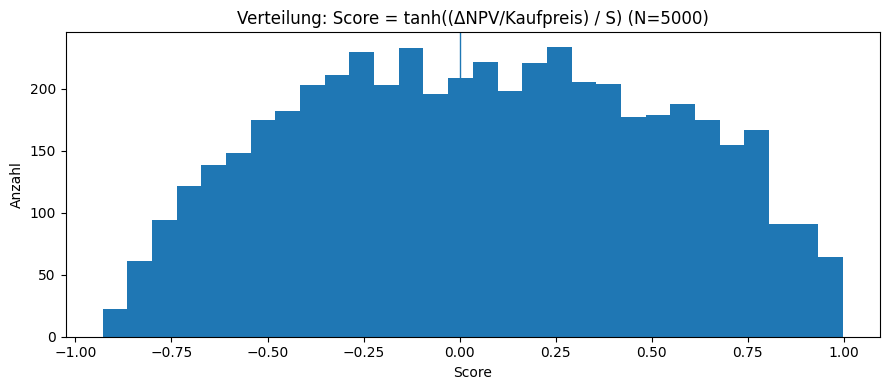

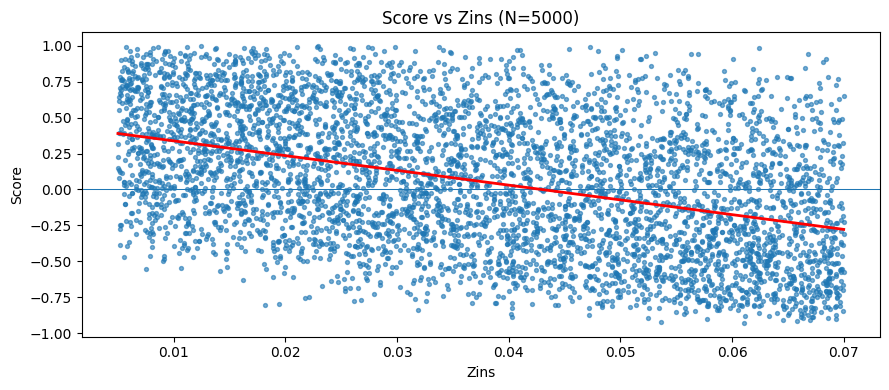

In [232]:
# -----------------------------
# Monte Carlo: bivariates Sampling über (Kaufpreis, Bruttomietrendite)
# -----------------------------

rng = np.random
N = 5000
H = 10

rows = []
for i in range(N):
    # ---------------------------------------------------------
    # 1) Realistisch gekoppelt: Preis + (Brutto-)Mietrendite -> Miete
    # ---------------------------------------------------------
    kaufpreis_pro_m2 = float(rng.uniform(500, 15000))

    # Bruttomietrendite p.a. (typisch grob 2% bis 7%; Modus ~3.5%)
    gross_yield = float(rng.triangular(left=0.015, mode=0.035, right=0.085))

    # Monatsmiete pro m² aus Yield abgeleitet
    mietpreis_pro_m2 = kaufpreis_pro_m2 * gross_yield / 12.0

    # kleine Streuung (lognormal), dann clippen auf plausible Mieten
    mietpreis_pro_m2 *= float(np.exp(rng.normal(0.0, 0.10)))  # ~10% Streuung
    mietpreis_pro_m2 = float(np.clip(mietpreis_pro_m2, 6.0, 40.0))

    # ---------------------------------------------------------
    # 2) Restliche Inputs (Ranges kannst du später feinjustieren)
    # ---------------------------------------------------------
    zins = float(rng.uniform(0.005, 0.07))
    tilgung = float(rng.uniform(0.01, 0.04))

    diskontsatz = float(rng.uniform(0.01, 0.06))
    rendite_invest = float(rng.uniform(0.02, 0.09))

    wohnflaeche_m2 = float(rng.uniform(35, 120))

    kaufnebenkosten_quote = float(rng.uniform(0.06, 0.12))
    eigenkapitalquote = float(rng.uniform(0.05, 0.40))
    preissteigerung_immobilie = float(rng.uniform(-0.02, 0.06))
    instandhaltung_quote = float(rng.uniform(0.003, 0.015))
    verkaufskosten_quote = float(rng.uniform(0.00, 0.05))
    steuersatz_veraeusserungsgewinn = float(rng.uniform(0.25, 0.30))

    # ---------------------------------------------------------
    # 3) ΔNPV berechnen
    # ---------------------------------------------------------
    try:
        delta = float(npv_delta(
            kaufpreis_pro_m2=kaufpreis_pro_m2,
            mietpreis_pro_m2=mietpreis_pro_m2,
            zins=zins,
            tilgung=tilgung,
            diskontsatz=diskontsatz,
            rendite_invest=rendite_invest,
            betrachtungszeitraum=H,
            wohnflaeche_m2=wohnflaeche_m2,
            mietsteigerung=0.02,
            kaufnebenkosten_quote=kaufnebenkosten_quote,
            eigenkapitalquote=eigenkapitalquote,
            preissteigerung_immobilie=preissteigerung_immobilie,
            instandhaltung_quote=instandhaltung_quote,
            verkaufskosten_quote=verkaufskosten_quote,
            steuersatz_veraeusserungsgewinn=steuersatz_veraeusserungsgewinn,
        ))
    except Exception:
        delta = np.nan

    rows.append({
        "kaufpreis_pro_m2": kaufpreis_pro_m2,
        "mietpreis_pro_m2": mietpreis_pro_m2,
        "gross_yield": gross_yield,

        "zins": zins,
        "tilgung": tilgung,
        "diskontsatz": diskontsatz,
        "rendite_invest": rendite_invest,
        "wohnflaeche_m2": wohnflaeche_m2,
        "kaufnebenkosten_quote": kaufnebenkosten_quote,
        "eigenkapitalquote": eigenkapitalquote,
        "preissteigerung_immobilie": preissteigerung_immobilie,
        "instandhaltung_quote": instandhaltung_quote,
        "verkaufskosten_quote": verkaufskosten_quote,
        "steuersatz_veraeusserungsgewinn": steuersatz_veraeusserungsgewinn,

        "betrachtungszeitraum": H,
        "delta_npv": delta,
    })

df_mc = pd.DataFrame(rows)

# -----------------------------
# 4) Score (robust, wenig Sättigung): relativ zum Kaufpreis skalieren
# -----------------------------
kaufpreis_total = df_mc["kaufpreis_pro_m2"] * df_mc["wohnflaeche_m2"]
df_mc["delta_rel"] = df_mc["delta_npv"] / kaufpreis_total

abs_rel = np.abs(df_mc["delta_rel"].dropna())

# robuster Scale: q90 von |Δ_rel|
S = float(abs_rel.quantile(0.90)) if len(abs_rel) else 1.0
if not np.isfinite(S) or S <= 0:
    S = 1.0

df_mc["score"] = np.tanh(df_mc["delta_rel"] / S)

print("Scale S (q90 von |ΔNPV/Kaufpreis|):", S)

x = df_mc["delta_rel"].dropna() / S
print("Anteil |x| > 1:", float((np.abs(x) > 1).mean()))
print("Anteil |x| > 2:", float((np.abs(x) > 2).mean()))
print("Anteil |x| > 3:", float((np.abs(x) > 3).mean()))

# -----------------------------
# 5) Checks / Outputs
# -----------------------------
display(df_mc.sort_values("score").head(10))
display(df_mc.sort_values("score").tail(10))

# Histogramm
plt.figure(figsize=(9,4))
plt.hist(df_mc["score"].dropna(), bins=30)
plt.axvline(0, linewidth=1)
plt.title("Verteilung: Score = tanh((ΔNPV/Kaufpreis) / S) (N=5000)")
plt.xlabel("Score")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

# Regression
plt.figure(figsize=(9,4))
plt.scatter(df_mc["zins"], df_mc["score"], s=8, alpha=0.6)
plt.axhline(0, linewidth=0.75)
# Regressionslinie (linear)
x = df_mc["zins"]
y = df_mc["score"]
m, b = np.polyfit(x.dropna(), y.loc[x.dropna().index], 1)
xx = np.linspace(x.min(), x.max(), 200)
plt.plot(xx, m*xx + b, linewidth=2, color="red")
plt.title("Score vs Zins (N=5000)")
plt.xlabel("Zins")
plt.ylabel("Score")
plt.tight_layout()
plt.show()